TP noté NLP

Web Scraping
Recherchez des articles scientifiques sur PubMed en utilisant un mot-clé spécifique et
extrayez les informations suivantes :

• Titre de l’article.
• Résumé (abstract).
• Auteurs.
Adaptez votre script pour itérer sur plusieurs pages afin de récupérer davantage
d’articles. Stockez ensuite ces informations dans un dataframe.

In [5]:
# Import des bibliothèques
import requests # Pour effectuer les requêtes HTTP
import pandas as pd  # Pour la manipulation de données (ex : dataframe)
from xml.etree import ElementTree # Pour l'analyse des fichiers xml

# Paramètres pour la recherche pour PubMed
search_term = "Spider Man"  # Mot-clé spécifique
max_results_per_page = 20   # Nombre d'articles par page
total_results = 100         # Total d'articles à récupérer

# URL de l'API PubMed fourni par NCBI pour la recherche
search_url = f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term={search_term}&retmode=xml&retmax={max_results_per_page}'

# Requête pour obtenir les IDs des articles
response = requests.get(search_url)
data = response.text

# Analyse des IDs des articles PubMed à partir de la réponse XML
root = ElementTree.fromstring(data) # Transformation de la réponse en arbre XML car Pubmed renvoie les résultats sous forme de XML 
# Puis conversion en un arbre XML pour une meilleure manipulation des données
id_list = [id_elem.text for id_elem in root.findall('.//Id')] # Extraction de tous les IDs (unique) des articles ensuite mis dans une liste

# Listes pour stocker les articles 
authors = [] # Auteurs
titles = [] # Titres
abstracts = [] # Résumés

# Nombre total de pages à parcourir,  en fonction du total d'articles et du nombre par page
total_pages = (total_results // max_results_per_page) + (1 if total_results % max_results_per_page != 0 else 0)

# Itération sur chaque page de résultats
for page in range(total_pages):
    # Calculer l'offset pour la pagination (retstart)
    retstart = page * max_results_per_page

    # Construction de l'URL pour récupérer les IDs des articles à partir de la page actuelle
    paginated_search_url = f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term={search_term}&retmode=xml&retmax={max_results_per_page}&retstart={retstart}'
    
    # Récupération des résultats de recherche paginés
    response = requests.get(paginated_search_url)
    data = response.text

    # Analyser les IDs des articles PubMed à partir de la réponse XML
    root = ElementTree.fromstring(data)
    id_list = [id_elem.text for id_elem in root.findall('.//Id')]
    
    # Si des articles sont trouvés, récupérer leurs détails
    if id_list:
        # Construction de l'URL pour récupérer les détails des articles via efetch.fcgi
        ids = ','.join(id_list)  # Les IDs doivent être séparés par des virgules
        details_url = f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id={ids}&retmode=xml'
        
        # Récupérartion des détails des articles
        response_details = requests.get(details_url)
        data_details = response_details.text
        
        # Analyse des détails des articles
        root_details = ElementTree.fromstring(data_details)
        for article in root_details.findall('.//PubmedArticle'):
            # Extraction du titre
            title = article.find('.//ArticleTitle').text if article.find('.//ArticleTitle') is not None else 'N/A'
            
            # Extraction des auteurs
            author_list = article.findall('.//Author')
            authors_text = ', '.join(
                f"{author.find('LastName').text} {author.find('ForeName').text}"
                for author in author_list
                if author.find('LastName') is not None and author.find('ForeName') is not None
            ) if author_list else 'N/A'
            
            # Extraction de l'abstract
            abstract = article.find('.//Abstract/AbstractText')
            abstract_text = abstract.text if abstract is not None else 'N/A'
            
            # Ajout des informations aux listes
            authors.append(authors_text)
            titles.append(title)
            abstracts.append(abstract_text)

# Création d'un dataFrame avec les colonnes appropriées
df = pd.DataFrame({
    'Author': authors,
    'Title': titles,
    'Abstract': abstracts
})

# Nom du fichier CSV
output_file = 'articles_pubmed.csv'

# Sauvegarde des résultats dans un fichier CSV
df.to_csv(output_file, index=False, encoding="utf-8")

# Message de confirmation
print(f"\nLes articles ont été sauvegardés dans le fichier {output_file}.")



Les articles ont été sauvegardés dans le fichier articles_pubmed.csv.


Analyse Exploratoire et Prétraitement
Une fois les informations dans un dataframe, réalisez les tâches suivantes :

• Appliquez une pipeline de prétraitement (comme vu dans les TD) sur les résumés et
les titres des articles. Les pipelines peuvent être différentes pour les deux champs.

Prétaitement des données en :

— Divisant les données en phrases en regroupant les tokens associés à leurs étiquettes.

— Vérifiant l’équilibre des étiquettes dans le jeu de données.

In [29]:
import requests
import pandas as pd
from xml.etree import ElementTree
import re
from collections import Counter

# Fonction pour diviser le texte en phrases et regrouper les tokens avec leurs étiquettes
def tokenize_and_label(text):
    if text is None:
        return [([], [])]
    sentences = re.split(r'[.!?]', text)
    token_labels = []
    for sentence in sentences:
        tokens = re.findall(r'\b\w+\b', sentence)
        labels = ['O'] * len(tokens)  # Assigner des étiquettes par défaut 'O' (outside)
        token_labels.append((tokens, labels))
    return token_labels

# Mot-clé de recherche pour PubMed
search_term = "Spider Man"  # Remplacer par ton mot-clé spécifique
max_results_per_page = 20   # Nombre d'articles par page
total_results = 100         # Total d'articles à récupérer

# URL de l'API PubMed (Entrez) pour la recherche
search_url = f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term={search_term}&retmode=xml&retmax={max_results_per_page}'

# Requête pour obtenir les IDs des articles
response = requests.get(search_url)
data = response.text

# Analyser les IDs des articles PubMed à partir de la réponse XML
root = ElementTree.fromstring(data)
id_list = [id_elem.text for id_elem in root.findall('.//Id')]

# Listes pour stocker les articles
authors = []
titles = []
abstracts = []

# Nombre total de pages à parcourir
total_pages = (total_results // max_results_per_page) + (1 if total_results % max_results_per_page != 0 else 0)

# Itération sur chaque page de résultats
for page in range(total_pages):
    # Calculer l'offset pour la pagination (retstart)
    retstart = page * max_results_per_page

    # Construction de l'URL pour récupérer les IDs des articles à partir de la page actuelle
    paginated_search_url = f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term={search_term}&retmode=xml&retmax={max_results_per_page}&retstart={retstart}'
    
    # Récupération des résultats de recherche paginés
    response = requests.get(paginated_search_url)
    data = response.text

    # Analyse des IDs des articles PubMed à partir de la réponse XML
    root = ElementTree.fromstring(data)
    id_list = [id_elem.text for id_elem in root.findall('.//Id')]
    
    # Si des articles sont trouvés, récupérer leurs détails
    if id_list:
        # Construdtion de l'URL pour récupérer les détails des articles via efetch.fcgi
        ids = ','.join(id_list)  # Les IDs doivent être séparés par des virgules
        details_url = f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id={ids}&retmode=xml'
        
        # Récupération des détails des articles
        response_details = requests.get(details_url)
        data_details = response_details.text
        
        # Analyse des détails des articles
        root_details = ElementTree.fromstring(data_details)
        for article in root_details.findall('.//PubmedArticle'):
            # Extraire le titre
            title = article.find('.//ArticleTitle').text if article.find('.//ArticleTitle') is not None else 'N/A'
            
            # Extraction des auteurs
            author_list = article.findall('.//Author')
            authors_text = ', '.join(
                f"{author.find('LastName').text} {author.find('ForeName').text}"
                for author in author_list
                if author.find('LastName') is not None and author.find('ForeName') is not None
            ) if author_list else 'N/A'
            
            # Extraction de l'abstract
            abstract = article.find('.//Abstract/AbstractText')
            abstract_text = abstract.text if abstract is not None else 'N/A'
            
            # Ajout des informations aux listes
            authors.append(authors_text)
            titles.append(title)
            abstracts.append(abstract_text)

# Création d'un DataFrame avec les colonnes appropriées
df = pd.DataFrame({
    'Author': authors,
    'Title': titles,
    'Abstract': abstracts
})

# Tokenizer et étiqueter les titres et résumés
df['Title Tokens and Labels'] = df['Title'].apply(tokenize_and_label)
df['Abstract Tokens and Labels'] = df['Abstract'].apply(tokenize_and_label)

# Vérification de l'équilibre des étiquettes dans le jeu de données
def check_label_balance(df, column):
    all_labels = [label for tokens_labels in df[column] for tokens, labels in tokens_labels for label in labels]
    label_counts = Counter(all_labels)
    return label_counts

title_label_balance = check_label_balance(df, 'Title Tokens and Labels')
abstract_label_balance = check_label_balance(df, 'Abstract Tokens and Labels')

print("Équilibre des étiquettes pour les titres :")
print(title_label_balance)

print("\nÉquilibre des étiquettes pour les résumés :")
print(abstract_label_balance)

# Nom du fichier CSV
output_file = 'articles_pubmed_pretraites.csv'

# Sauvegarder les résultats dans un fichier CSV
df.to_csv(output_file, index=False, encoding="utf-8")

# Message de confirmation
print(f"\nLes articles ont été sauvegardés dans le fichier {output_file}.")


Équilibre des étiquettes pour les titres :
Counter({'O': 1356})

Équilibre des étiquettes pour les résumés :
Counter({'O': 12984})

Les articles ont été sauvegardés dans le fichier articles_pubmed_pretraites.csv.


In [30]:
pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


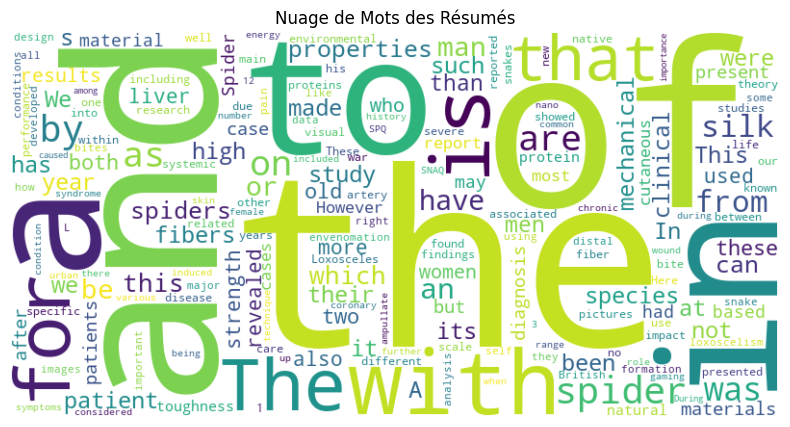

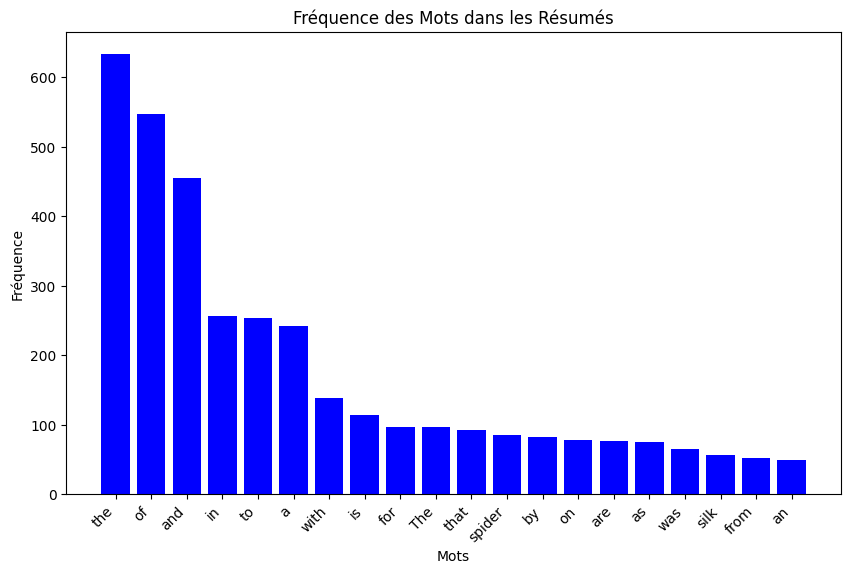

In [1]:
import requests
import pandas as pd
from xml.etree import ElementTree
import re # 
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Fonction pour diviser le texte en phrases et regrouper les tokens avec leurs étiquettes
def tokenize_and_label(text):
    sentences = re.split(r'[.!?]', text)
    token_labels = []
    for sentence in sentences:
        tokens = re.findall(r'\b\w+\b', sentence)
        labels = ['O'] * len(tokens)  # Assigner des étiquettes par défaut 'O' (outside)
        token_labels.append((tokens, labels))
    return token_labels

# Mot-clé de recherche pour PubMed
search_term = "Spider Man"  # Remplacer par ton mot-clé spécifique
max_results_per_page = 20   # Nombre d'articles par page
total_results = 100         # Total d'articles à récupérer

# URL de l'API PubMed (Entrez) pour la recherche
search_url = f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term={search_term}&retmode=xml&retmax={max_results_per_page}'

# Requête pour obtenir les IDs des articles
response = requests.get(search_url)
data = response.text

# Analyser les IDs des articles PubMed à partir de la réponse XML
root = ElementTree.fromstring(data)
id_list = [id_elem.text for id_elem in root.findall('.//Id')]

# Listes pour stocker les articles
authors = []
titles = []
abstracts = []

# Nombre total de pages à parcourir
total_pages = (total_results // max_results_per_page) + (1 if total_results % max_results_per_page != 0 else 0)

# Itérer sur chaque page de résultats
for page in range(total_pages):
    # Calculer l'offset pour la pagination (retstart)
    retstart = page * max_results_per_page

    # Construire l'URL pour récupérer les IDs des articles à partir de la page actuelle
    paginated_search_url = f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term={search_term}&retmode=xml&retmax={max_results_per_page}&retstart={retstart}'
    
    # Récupérer les résultats de recherche paginés
    response = requests.get(paginated_search_url)
    data = response.text

    # Analyser les IDs des articles PubMed à partir de la réponse XML
    root = ElementTree.fromstring(data)
    id_list = [id_elem.text for id_elem in root.findall('.//Id')]
    
    # Si des articles sont trouvés, récupérer leurs détails
    if id_list:
        # Construire l'URL pour récupérer les détails des articles via efetch.fcgi
        ids = ','.join(id_list)  # Les IDs doivent être séparés par des virgules
        details_url = f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id={ids}&retmode=xml'
        
        # Récupération des détails des articles
        response_details = requests.get(details_url)
        data_details = response_details.text
        
        # Analyse des détails des articles
        root_details = ElementTree.fromstring(data_details)
        for article in root_details.findall('.//PubmedArticle'):
            # Extraire le titre
            title = article.find('.//ArticleTitle').text if article.find('.//ArticleTitle') is not None else 'N/A'
            
            # Extration des auteurs
            author_list = article.findall('.//Author')
            authors_text = ', '.join(
                f"{author.find('LastName').text} {author.find('ForeName').text}"
                for author in author_list
                if author.find('LastName') is not None and author.find('ForeName') is not None
            ) if author_list else 'N/A'
            
            # Extraction de l'abstract
            abstract = article.find('.//Abstract/AbstractText')
            abstract_text = abstract.text if abstract is not None else 'N/A'
            
            # Ajout des informations aux listes
            authors.append(authors_text)
            titles.append(title)
            abstracts.append(abstract_text)

# Création d'un DataFrame avec les colonnes appropriées
df = pd.DataFrame({
    'Author': authors,
    'Title': titles,
    'Abstract': abstracts
})

# Calcul de la fréquence des mots présents dans les résumés
def calculate_word_frequencies(texts):
    all_words = []
    for text in texts:
        words = re.findall(r'\b\w+\b', text)
        all_words.extend(words)
    return Counter(all_words) # Compteur de mots

# Création d'un nuage de mots à partir des résumés
def create_word_cloud(frequencies):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frequencies)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nuage de Mots des Résumés')
    plt.show()

# Calcul de la fréquence des mots dans les résumés
abstract_word_frequencies = calculate_word_frequencies(df['Abstract'])

# Création et affichage le nuage de mots
create_word_cloud(abstract_word_frequencies)

# Visualisation de la distribution des fréquences des mots
def plot_word_frequencies(frequencies, top_n=20):
    most_common_words = frequencies.most_common(top_n)
    words, counts = zip(*most_common_words)
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color='blue')
    plt.xticks(rotation=45, ha='right')
    plt.title('Fréquence des Mots dans les Résumés')
    plt.xlabel('Mots')
    plt.ylabel('Fréquence')
    plt.show()

# Visualiser la distribution des fréquences des mots
plot_word_frequencies(abstract_word_frequencies)

